Шаг 1: Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import shap
import joblib
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Библиотеки импортированы.")

c:\Users\a84405958\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Библиотеки импортированы.


Шаг 2: Загрузка и первичный анализ данных

In [2]:
file_path = 'TZ.csv'
try:
    df = pd.read_csv(file_path)
    print("Данные загружены")
    print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов.")
except FileNotFoundError:
    print(f"Ошибка'{file_path}'")

print("\n" + "Первые 5 строк датасета ")
display(df.head())\

print("\n" + " Информация о столбцах и пропусках (df.info()) ")
df.info()

print("\n" + " Статистическая сводка (df.describe()) ")
display(df.describe(include='all'))

Данные загружены
Размер датасета: 15000 строк, 14 столбцов.

Первые 5 строк датасета 


,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
0,0,15709511,Тестов55,754,Астана,Male,40,8,102954.68,2,1,1,149238.35,0
1,1,15592761,Тестов539,579,Алматы,Female,28,1,NaN,2,1,0,64869.32,0
2,2,15579914,Тестов275,744,Алматы,Female,56,5,NaN,1,1,0,158816.03,1
3,3,15669611,Есенгельдиев,697,Алматы,Male,29,2,NaN,2,1,0,55775.72,0
4,4,15761775,Тестов451,628,Алматы,Female,22,9,NaN,2,1,0,49653.39,0



 Информация о столбцах и пропусках (df.info()) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15000 non-null  int64  
 1   ID_клиента          15000 non-null  int64  
 2   фамилия             15000 non-null  object 
 3   кредитный_рейтинг   15000 non-null  int64  
 4   город               15000 non-null  object 
 5   пол                 15000 non-null  object 
 6   возраст             15000 non-null  int64  
 7   стаж_в_банке        15000 non-null  int64  
 8   баланс_депозита     5316 non-null   float64
 9   число_продуктов     15000 non-null  int64  
 10  есть_кредитка       15000 non-null  int64  
 11  активный_клиент     15000 non-null  int64  
 12  оценочная_зарплата  15000 non-null  float64
 13  ушел_из_банка       15000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.6+

,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
count,15000.000000,1.500000e+04,15000,15000.000000,15000,15000,15000.000000,15000.000000,5316.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
unique,NaN,NaN,836,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Тестов677,NaN,Алматы,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,34,NaN,8971,8358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7499.500000,1.579653e+07,NaN,658.851467,NaN,NaN,37.888000,5.033333,121681.886227,1.590733,0.783200,0.500200,1.181348e+05,0.203867
std,4330.271354,1.270937e+07,NaN,72.587026,NaN,NaN,8.257409,2.808359,22875.768239,0.535587,0.412079,0.500017,4.680311e+04,0.402884
min,0.000000,1.556578e+07,NaN,431.000000,NaN,NaN,18.000000,0.000000,753.370000,1.000000,0.000000,0.000000,1.158000e+01,0.000000
25%,3749.750000,1.563449e+07,NaN,602.000000,NaN,NaN,32.000000,3.000000,106392.525000,1.000000,1.000000,0.000000,8.362960e+04,0.000000
50%,7499.500000,1.569053e+07,NaN,662.000000,NaN,NaN,37.000000,5.000000,122570.690000,2.000000,1.000000,1.000000,1.235878e+05,0.000000
75%,11249.250000,1.575758e+07,NaN,709.000000,NaN,NaN,42.000000,7.000000,137226.870000,2.000000,1.000000,1.000000,1.575585e+05,0.000000


Шаг 3: Разведочный анализ данных (EDA)

 Анализ целевой переменной 
Абсолютные значения:
ушел_из_банка
0    11942
1     3058
Name: count, dtype: int64

Процентное соотношение:
ушел_из_банка
0    79.61
1    20.39
Name: proportion, dtype: float64


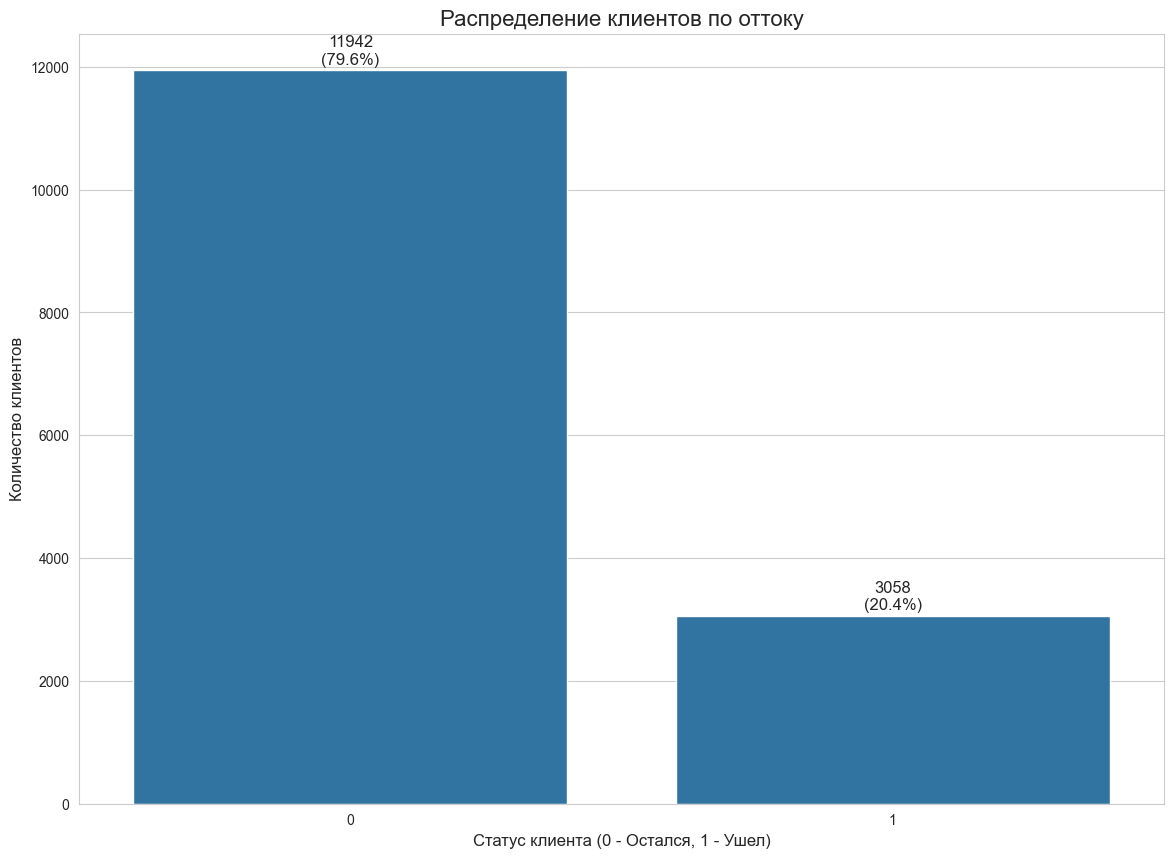

In [3]:
print(" Анализ целевой переменной ")
churn_counts = df['ушел_из_банка'].value_counts()
churn_percentage = df['ушел_из_банка'].value_counts(normalize=True) * 100

print("Абсолютные значения:")
print(churn_counts)
print("\nПроцентное соотношение:")
print(round(churn_percentage, 2))

plt.figure(figsize=(14, 10))
sns.countplot(x='ушел_из_банка', data=df)

plt.title('Распределение клиентов по оттоку', fontsize=16)
plt.xlabel('Статус клиента (0 - Остался, 1 - Ушел)', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)

for index, value in enumerate(churn_counts):
    plt.text(index, value + 100, f"{value}\n({churn_percentage[index]:.1f}%)", ha='center', fontsize=12)

plt.show()

Шаг 3.2: Анализ категориальных признаков

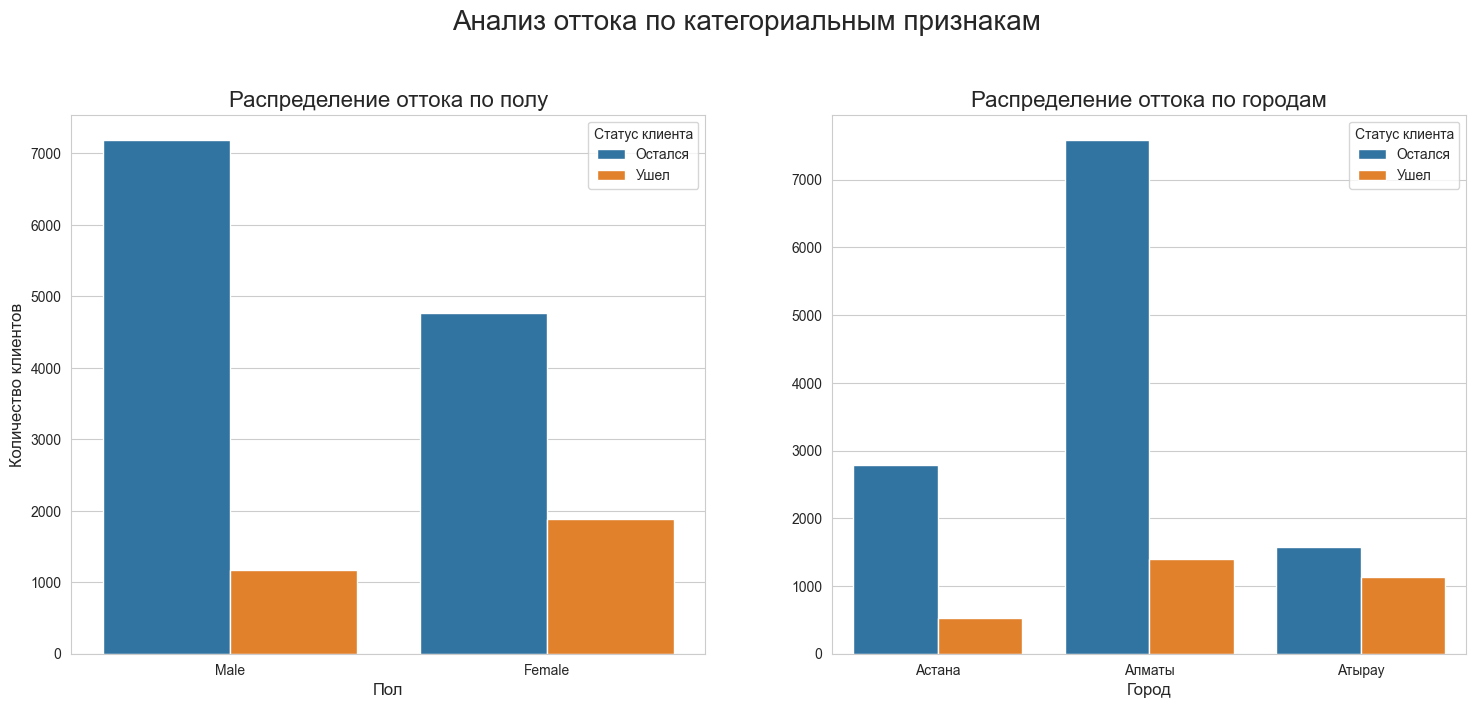


 Процент оттока по категориям 

Отток по полу:
ушел_из_банка      0      1
пол                        
Female         71.70  28.30
Male           85.91  14.09

Отток по городам:
ушел_из_банка      0      1
город                      
Алматы         84.47  15.53
Астана         84.10  15.90
Атырау         58.01  41.99


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.countplot(x='пол', hue='ушел_из_банка', data=df, ax=axes[0])
axes[0].set_title('Распределение оттока по полу', fontsize=16)
axes[0].set_xlabel('Пол', fontsize=12)
axes[0].set_ylabel('Количество клиентов', fontsize=12)
axes[0].legend(title='Статус клиента', labels=['Остался', 'Ушел'])

sns.countplot(x='город', hue='ушел_из_банка', data=df, ax=axes[1])
axes[1].set_title('Распределение оттока по городам', fontsize=16)
axes[1].set_xlabel('Город', fontsize=12)
axes[1].set_ylabel('')
axes[1].legend(title='Статус клиента', labels=['Остался', 'Ушел'])

plt.suptitle('Анализ оттока по категориальным признакам', fontsize=20, y=1.03)
plt.show()

print("\n Процент оттока по категориям ")
print("\nОтток по полу:")
gender_churn = df.groupby('пол')['ушел_из_банка'].value_counts(normalize=True).unstack()
print(round(gender_churn * 100, 2))

print("\nОтток по городам:")
city_churn = df.groupby('город')['ушел_из_банка'].value_counts(normalize=True).unstack()
print(round(city_churn * 100, 2))

Шаг 3.3 Анализ числовых признаков

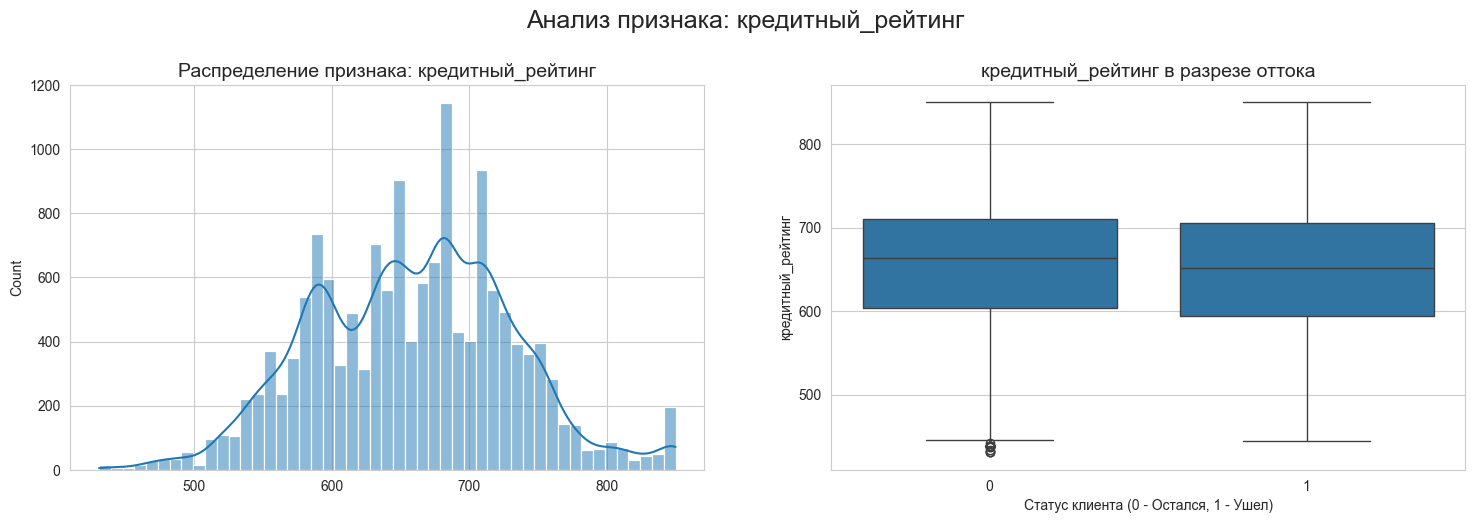

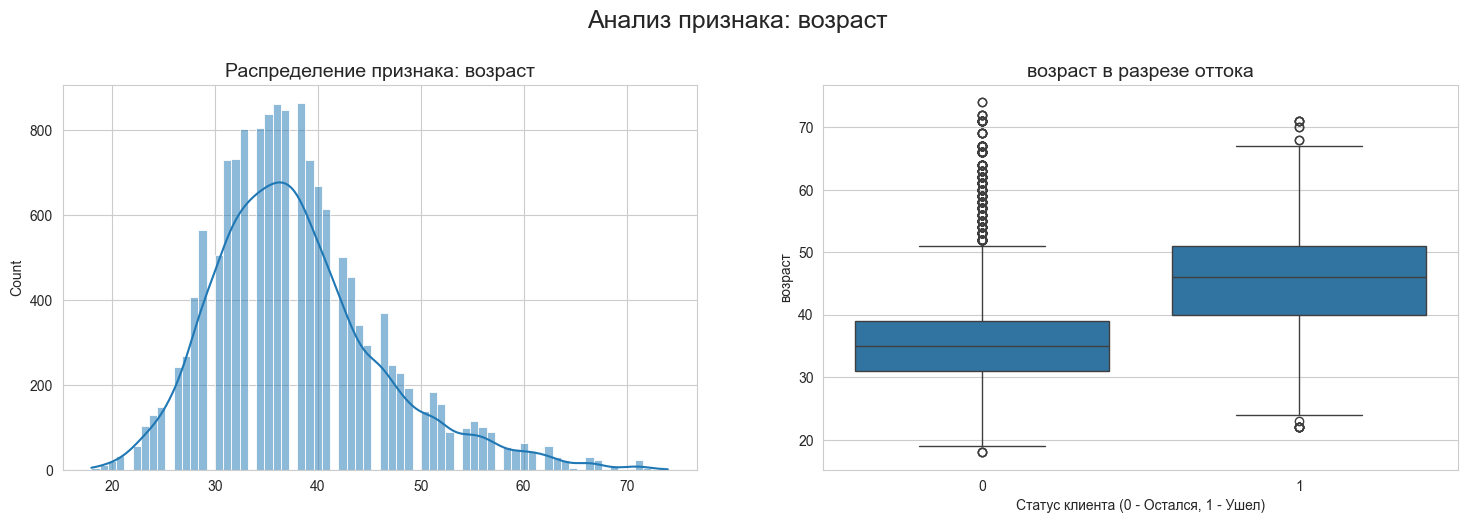

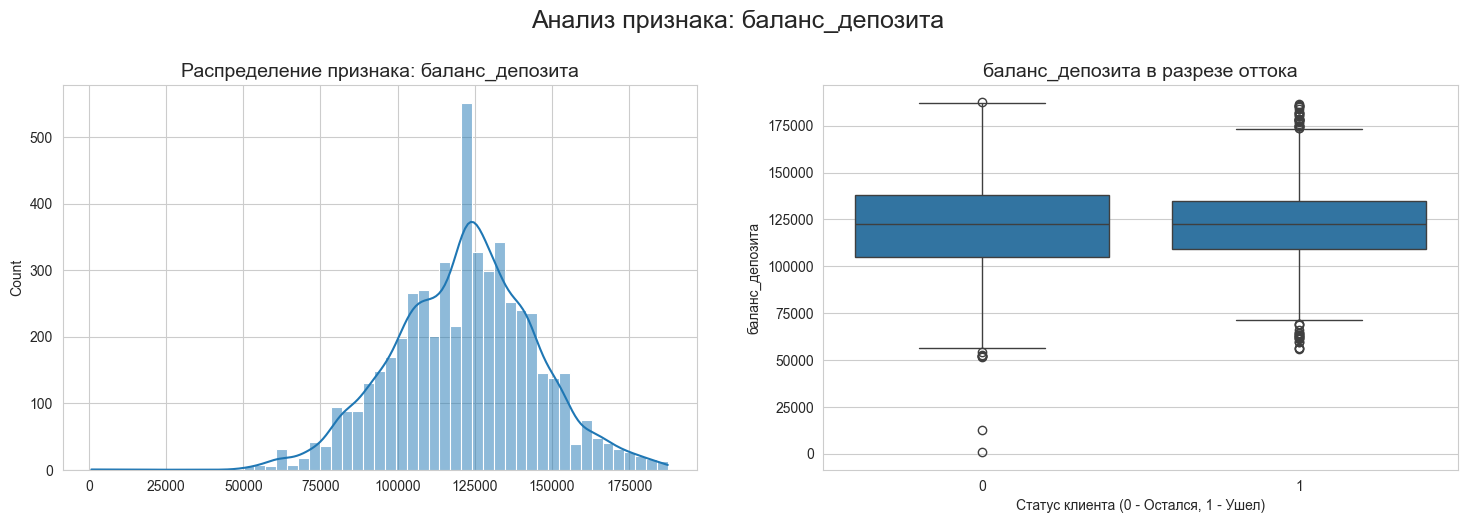

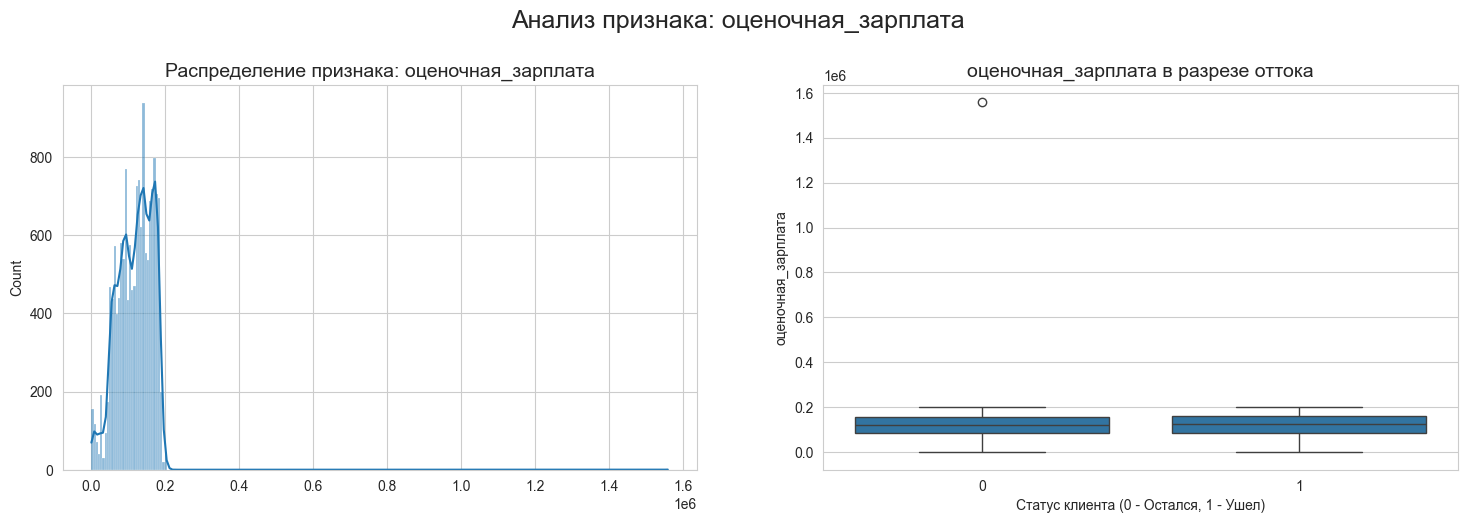

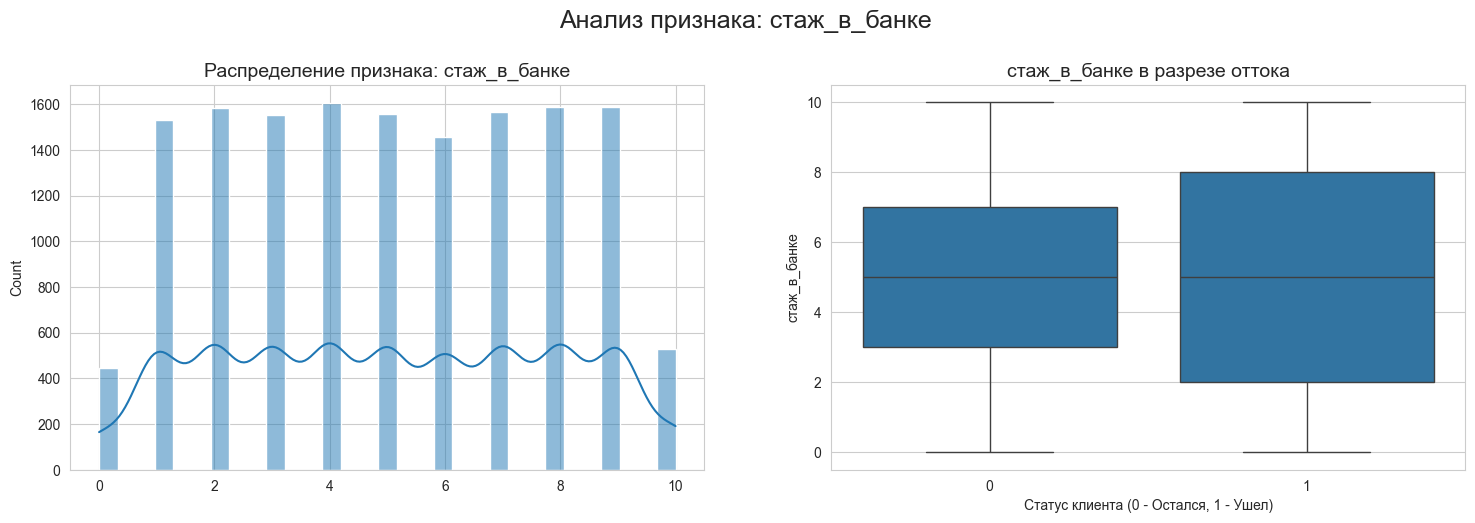

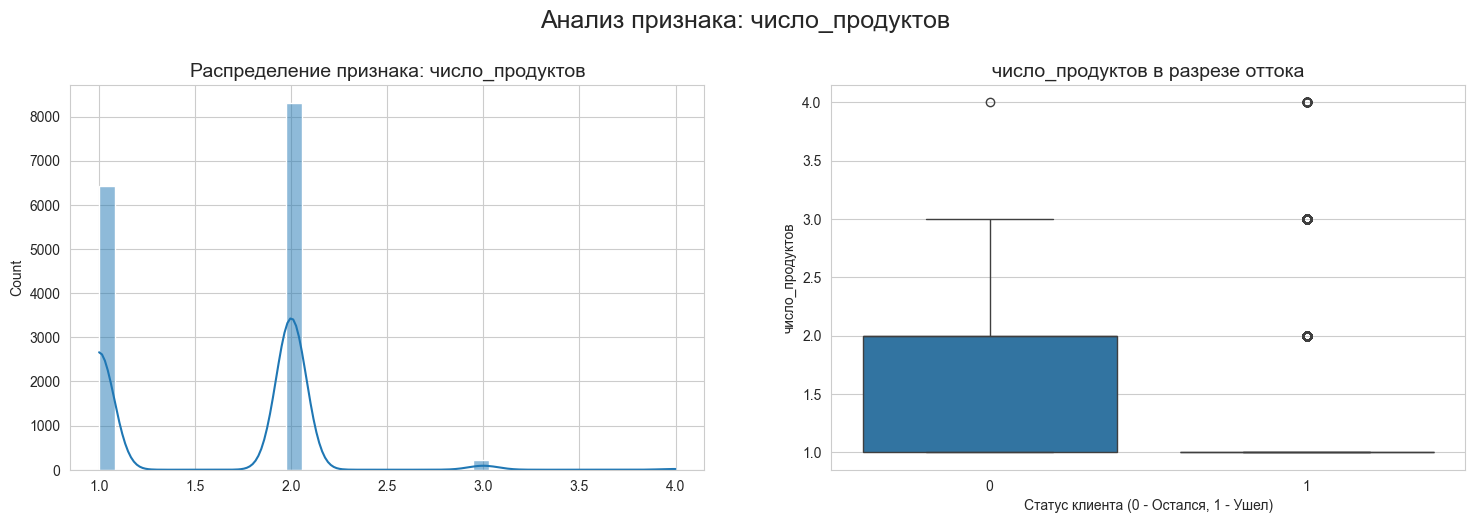

In [5]:
numeric_features = ['кредитный_рейтинг', 'возраст', 'баланс_депозита', 'оценочная_зарплата', 'стаж_в_банке', 'число_продуктов']

for feature in numeric_features:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    sns.histplot(df[feature], kde=True, ax=axes[0])
    axes[0].set_title(f'Распределение признака: {feature}', fontsize=14)
    axes[0].set_xlabel('')
    
    sns.boxplot(x='ушел_из_банка', y=feature, data=df, ax=axes[1])
    axes[1].set_title(f'{feature} в разрезе оттока', fontsize=14)
    axes[1].set_xlabel('Статус клиента (0 - Остался, 1 - Ушел)')
    
    plt.suptitle(f'Анализ признака: {feature}', fontsize=18, y=1.03)
    plt.show()

Шаг 3.4 Анализ пропусков и корреляций

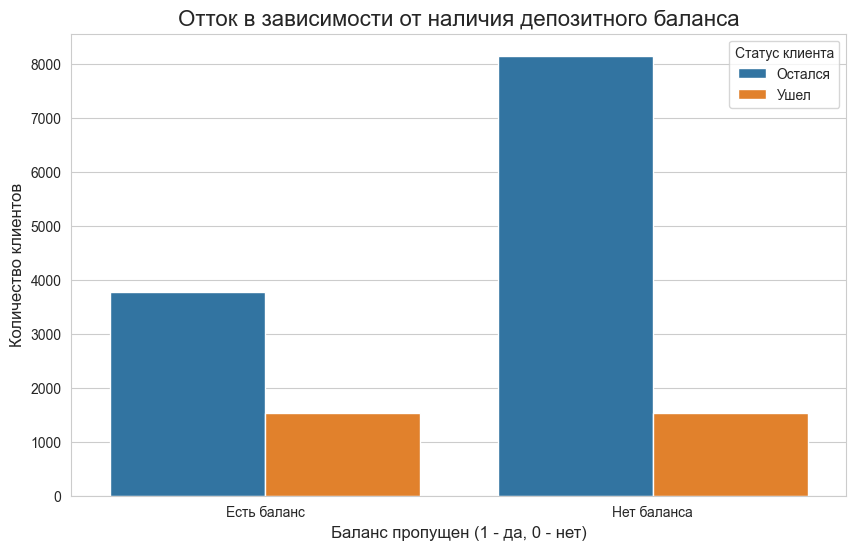

 Процент оттока в зависимости от наличия баланса 
ушел_из_банка        0      1
баланс_пропущен              
0                71.20  28.80
1                84.23  15.77

 Тепловая карта корреляций 


C:\Users\a84405958\AppData\Local\Temp\ipykernel_1616\3454947173.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_for_corr['баланс_депозита'].fillna(0, inplace=True)


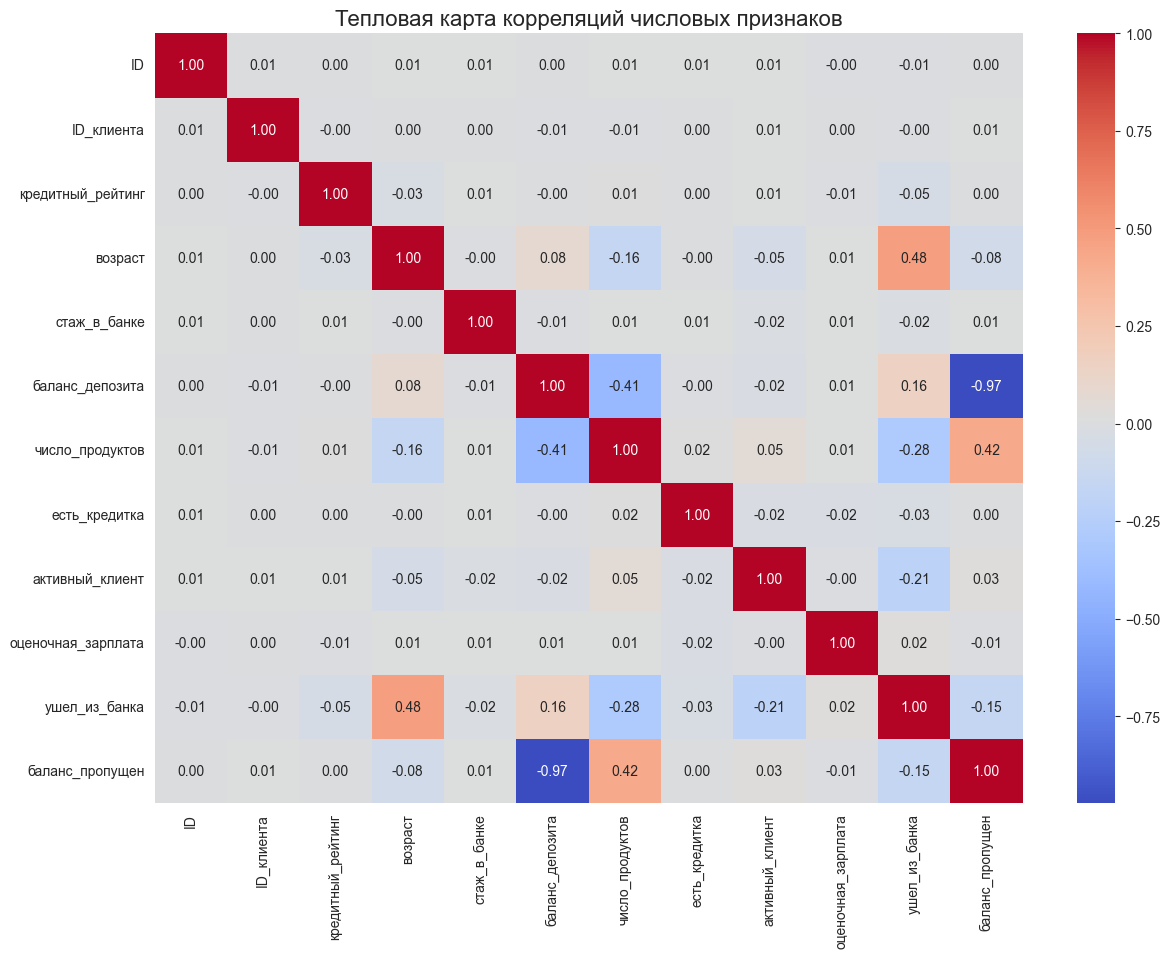

In [6]:
df['баланс_пропущен'] = df['баланс_депозита'].isnull().astype(int)

plt.figure(figsize=(10, 6))
sns.countplot(x='баланс_пропущен', hue='ушел_из_банка', data=df)
plt.title('Отток в зависимости от наличия депозитного баланса', fontsize=16)
plt.xlabel('Баланс пропущен (1 - да, 0 - нет)', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks([0, 1], ['Есть баланс', 'Нет баланса'])
plt.legend(title='Статус клиента', labels=['Остался', 'Ушел'])
plt.show()

print(" Процент оттока в зависимости от наличия баланса ")
balance_churn = df.groupby('баланс_пропущен')['ушел_из_банка'].value_counts(normalize=True).unstack()
print(round(balance_churn * 100, 2))


print("\n Тепловая карта корреляций ")

df_for_corr = df.copy()
df_for_corr['баланс_депозита'].fillna(0, inplace=True)

numeric_cols = df_for_corr.select_dtypes(include=np.number)

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Тепловая карта корреляций числовых признаков', fontsize=16)
plt.show()

df.drop('баланс_пропущен', axis=1, inplace=True)

Шаг 3.5: Создание новых признаков (Feature Engineering)

In [7]:
df_featured = df.copy()

df_featured['balance_salary_ratio'] = df_featured['баланс_депозита'] / (df_featured['оценочная_зарплата'].replace(0, 1e-6))
df_featured['tenure_by_age'] = df_featured['стаж_в_банке'] / (df_featured['возраст'].replace(0, 1e-6))
df_featured['balance_per_product'] = df_featured['баланс_депозита'] / df_featured['число_продуктов']
df_featured['is_balance_zero'] = (df_featured['баланс_депозита'] == 0).astype(int)
df_featured.fillna(0, inplace=True)
df_featured.replace([np.inf, -np.inf], 0, inplace=True)

print("\nПример новых признаков:")
display(df_featured[['balance_salary_ratio', 'tenure_by_age', 'balance_per_product', 'is_balance_zero']].head())



Пример новых признаков:


,balance_salary_ratio,tenure_by_age,balance_per_product,is_balance_zero
0,0.689867,0.200000,51477.34,0
1,0.000000,0.035714,0.00,0
2,0.000000,0.089286,0.00,0
3,0.000000,0.068966,0.00,0
4,0.000000,0.409091,0.00,0


### Шаг 4: Предобработка данных (Data Preprocessing)

In [8]:
df_processed = df_featured.copy()
df_processed = df_processed.drop(['ID', 'ID_клиента', 'фамилия'], axis=1)
print(" Ненужные столбцы удалены.")

df_processed['баланс_депозита'].fillna(0, inplace=True)
print(" Пропуски в балансе заменены на 0.")

df_processed = pd.get_dummies(df_processed, columns=['город', 'пол'], drop_first=True)
print(" Категориальные признаки преобразованы.")

X = df_processed.drop('ушел_из_банка', axis=1)
y = df_processed['ушел_из_банка']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(" Данные разделены на обучающую и тестовую выборки.")
print(f"Размер обучающей выборки (X_train): {X_train.shape}")
print(f"Размер тестовой выборки (X_test):  {X_test.shape}")

print("\n Финальный вид данных (первые 5 строк X_train)")
display(X_train.head())

 Ненужные столбцы удалены.
 Пропуски в балансе заменены на 0.
 Категориальные признаки преобразованы.
 Данные разделены на обучающую и тестовую выборки.
Размер обучающей выборки (X_train): (12000, 15)
Размер тестовой выборки (X_test):  (3000, 15)

 Финальный вид данных (первые 5 строк X_train)


C:\Users\a84405958\AppData\Local\Temp\ipykernel_1616\483891886.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['баланс_депозита'].fillna(0, inplace=True)


,кредитный_рейтинг,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,balance_salary_ratio,tenure_by_age,balance_per_product,is_balance_zero,город_Астана,город_Атырау,пол_Male
9451,567,43,8,0.00,1,1,0,71843.95,0.000000,0.186047,0.00,0,False,False,True
2071,612,35,4,104498.79,1,1,0,51112.80,2.044474,0.114286,104498.79,0,False,True,True
77,619,34,2,0.00,2,1,1,141152.28,0.000000,0.058824,0.00,0,False,False,True
5464,710,43,2,0.00,2,1,1,175072.47,0.000000,0.046512,0.00,0,False,False,False
8844,662,40,2,120165.40,1,1,1,72993.65,1.646245,0.050000,120165.40,0,False,True,True


### Шаг 5: Построение и оценка моделей

Шаг 5.1: Модель №1 — Логистическая регрессия (Baseline)


 Оценка на тестовых данных 
ROC-AUC:   0.8838
Precision: 0.5334
Recall:    0.8088
F1-score:  0.6429

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2388
           1       0.53      0.81      0.64       612

    accuracy                           0.82      3000
   macro avg       0.74      0.81      0.76      3000
weighted avg       0.86      0.82      0.83      3000



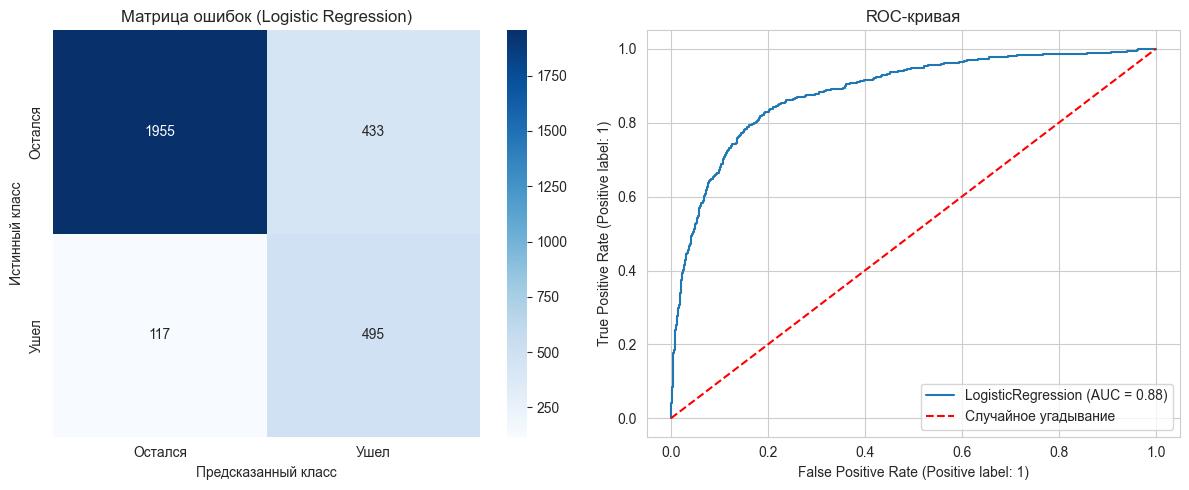

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

print("\n Оценка на тестовых данных ")
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался', 'Ушел'], yticklabels=['Остался', 'Ушел'])
plt.title('Матрица ошибок (Logistic Regression)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test, ax=plt.gca())
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайное угадывание')
plt.legend()

plt.tight_layout()
plt.show()

Шаг 5.2: Модель №2 — Случайный лес (Random Forest)


 Оценка на тестовых данных 
ROC-AUC:   0.9225
Precision: 0.7918
Recall:    0.6029
F1-score:  0.6846

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2388
           1       0.79      0.60      0.68       612

    accuracy                           0.89      3000
   macro avg       0.85      0.78      0.81      3000
weighted avg       0.88      0.89      0.88      3000



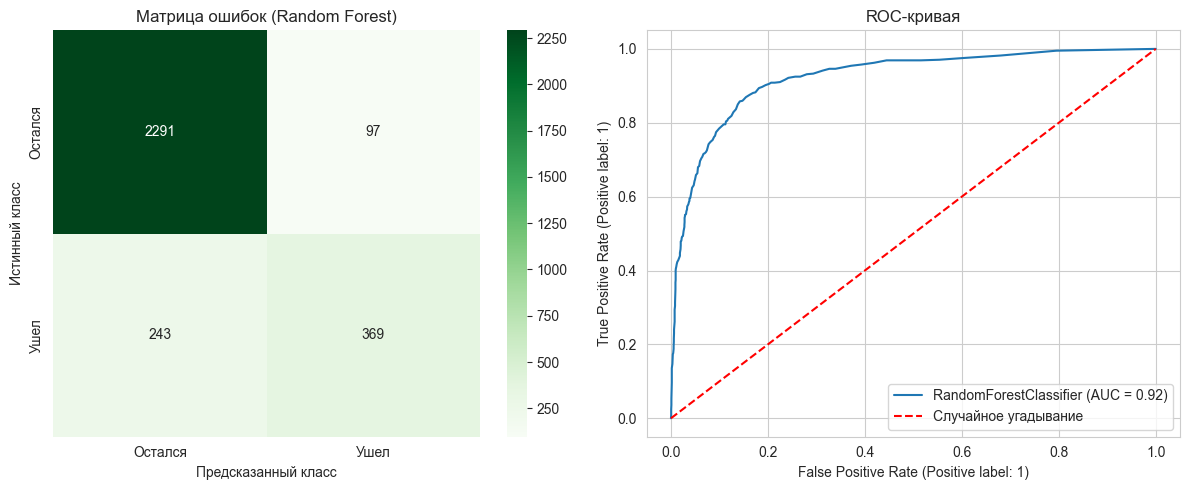

In [10]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced', n_jobs=-1)

rf_model.fit(X_train, y_train)

print("\n Оценка на тестовых данных ")
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Остался', 'Ушел'], yticklabels=['Остался', 'Ушел'])
plt.title('Матрица ошибок (Random Forest)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=plt.gca())
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайное угадывание')
plt.legend()

plt.tight_layout()
plt.show()

Шаг 5.3: Модель №3 — XGBoost

 Модель обучена.

 Оценка на тестовых данных 
ROC-AUC:   0.9259
Precision: 0.6439
Recall:    0.8154
F1-score:  0.7195

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      2388
           1       0.64      0.82      0.72       612

    accuracy                           0.87      3000
   macro avg       0.80      0.85      0.82      3000
weighted avg       0.89      0.87      0.88      3000



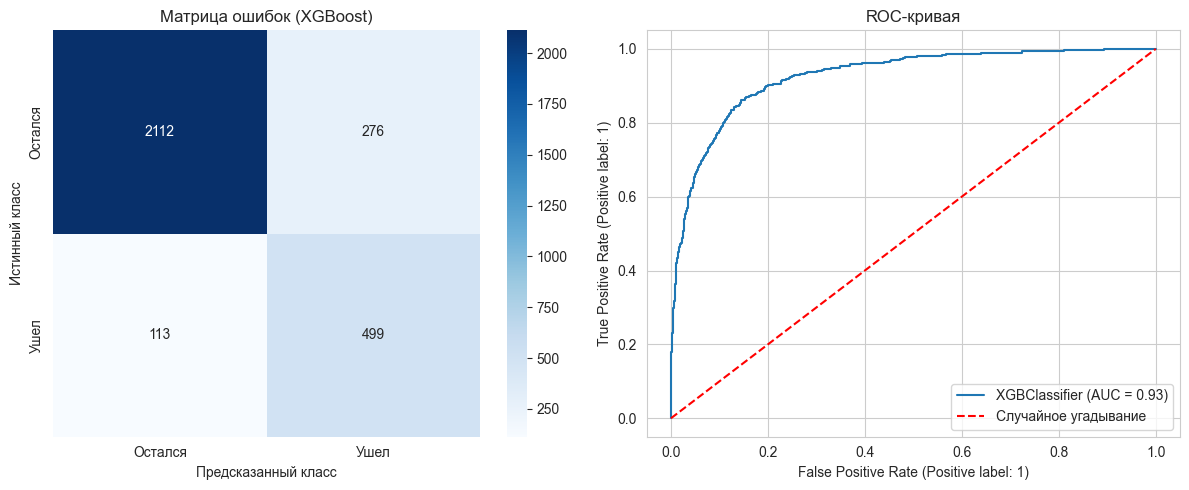

In [11]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=200, 
    random_state=42, 
    scale_pos_weight=scale_pos_weight, 
    n_jobs=-1,
    early_stopping_rounds=10
)

eval_set = [(X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print(" Модель обучена.")
print("\n Оценка на тестовых данных ")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался', 'Ушел'], yticklabels=['Остался', 'Ушел'])
plt.title('Матрица ошибок (XGBoost)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=plt.gca())
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайное угадывание')
plt.legend()

plt.tight_layout()
plt.show()

### Шаг 6: Сводное сравнение моделей

,ROC-AUC,Precision,Recall,F1-score
XGBoost,0.925916,0.643871,0.815359,0.719539
Random Forest,0.922473,0.791845,0.602941,0.684601
Logistic Regression,0.883832,0.533405,0.808824,0.642857


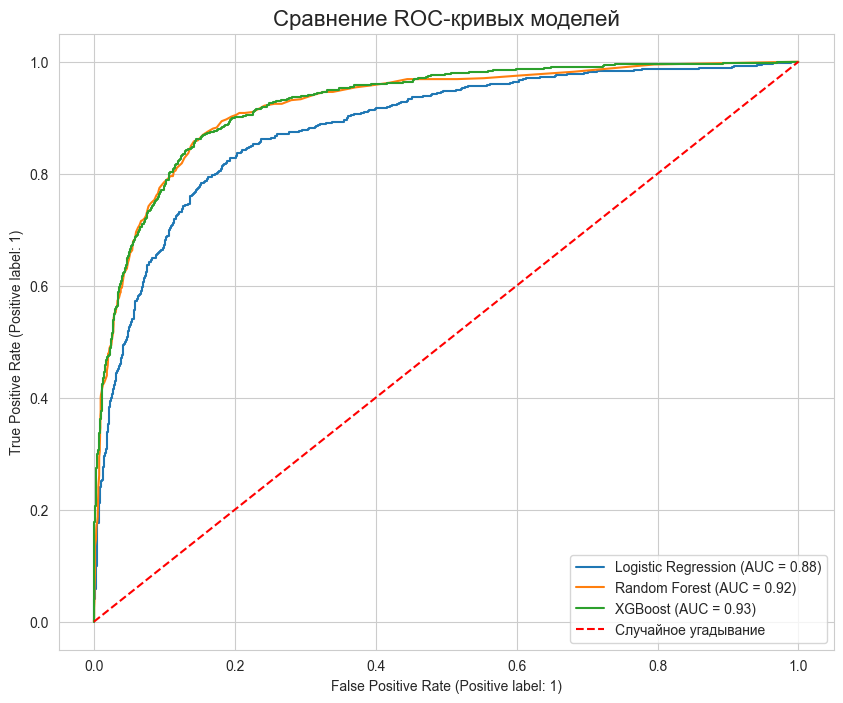

In [12]:
comparison_data = {
    "Logistic Regression": {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba_lr),
        "Precision": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1-score": f1_score(y_test, y_pred_lr)
    },
    "Random Forest": {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-score": f1_score(y_test, y_pred_rf)
    },
    "XGBoost": {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb),
        "F1-score": f1_score(y_test, y_pred_xgb)
    }
}

comparison_df = pd.DataFrame(comparison_data).T

display(comparison_df.sort_values(by="ROC-AUC", ascending=False))
plt.figure(figsize=(10, 8))
ax = plt.gca()

RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name='Random Forest', ax=ax)
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, name='XGBoost', ax=ax)

plt.plot([0, 1], [0, 1], 'r--', label='Случайное угадывание')
plt.title('Сравнение ROC-кривых моделей', fontsize=16)
plt.legend()
plt.show()

### Шаг 7: Подбор гиперпараметров для XGBoost

In [13]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [5, 7, 10],         
    'learning_rate': [0.05, 0.1],     
    'subsample': [0.7, 1.0]           
}

xgb_for_grid = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_for_grid,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_xgb.fit(X_train, y_train)

print(f"найденные GridSearchCV: {grid_search_xgb.best_params_}")
print(f"значение ROC-AUC на кросс-валидации: {grid_search_xgb.best_score_:.4f}")
best_xgb_model = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
найденные GridSearchCV: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
значение ROC-AUC на кросс-валидации: 0.9335


### Шаг 8: Финальная оценка лучшей модели (Optimized XGBoost)


Метрики на тестовых данных
ROC-AUC:   0.9332
Precision: 0.6230
Recall:    0.8480
F1-score:  0.7183

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2388
           1       0.62      0.85      0.72       612

    accuracy                           0.86      3000
   macro avg       0.79      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



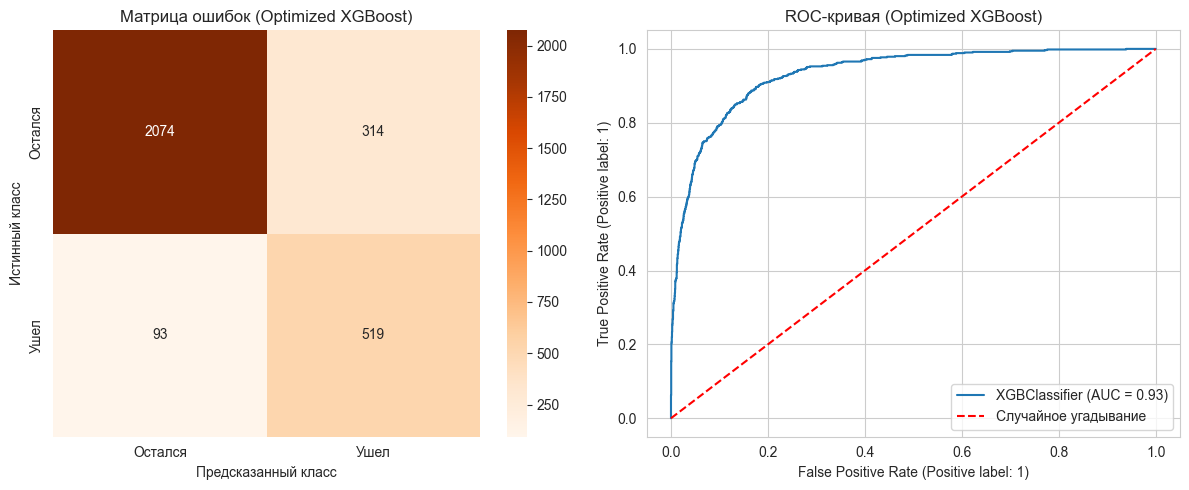

In [14]:
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nМетрики на тестовых данных")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_best_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best_xgb):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_best_xgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)
sns.heatmap(cm_best_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Остался', 'Ушел'], yticklabels=['Остался', 'Ушел'])
plt.title('Матрица ошибок (Optimized XGBoost)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test, ax=plt.gca())
plt.title('ROC-кривая (Optimized XGBoost)')
plt.plot([0, 1], [0, 1], 'r--', label='Случайное угадывание')
plt.legend()

plt.tight_layout()
plt.show()

### Шаг 9: Валидация и интерпретация с помощью SHAP


 SHAP Summary Plot (Bar) 


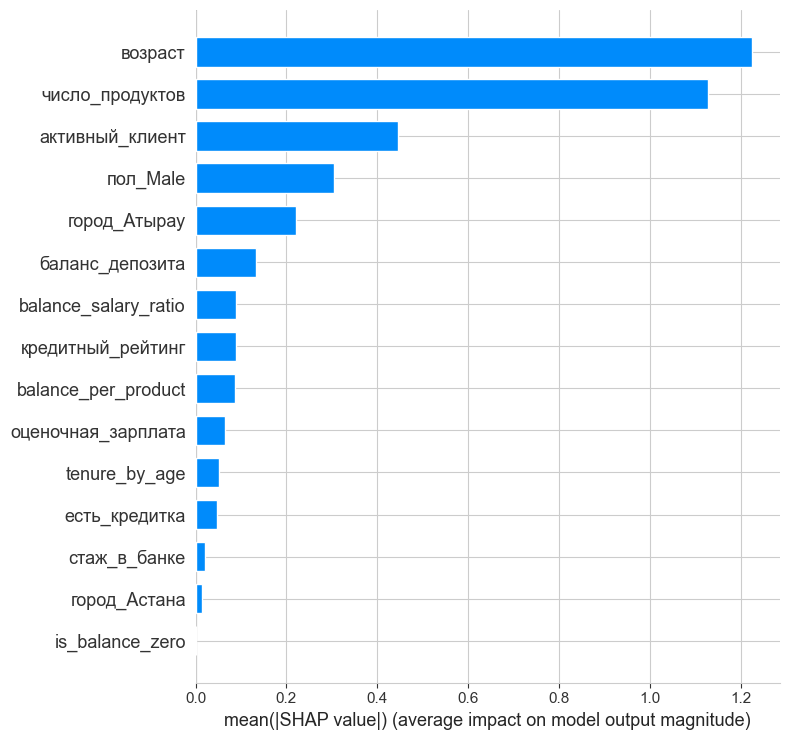


 SHAP Summary Plot (Beeswarm) 


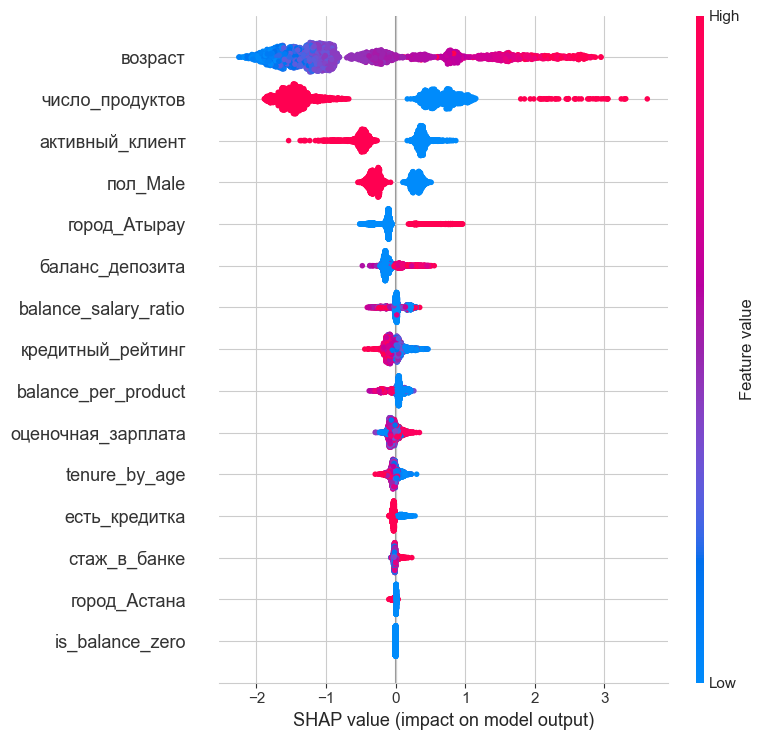


 SHAP Dependence Plot для признака 'возраст' 


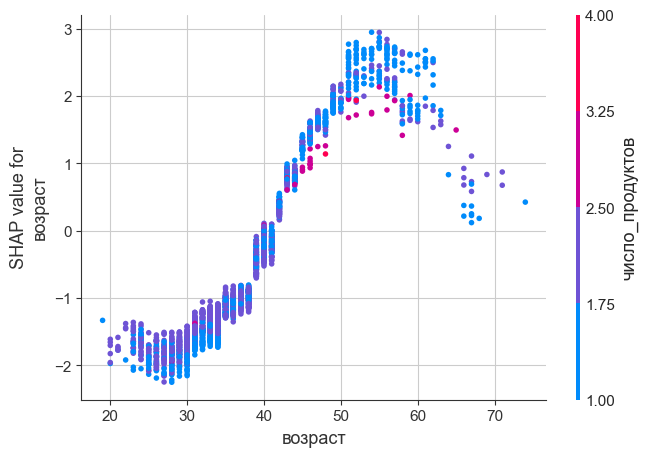

In [15]:
joblib.dump(best_xgb_model, 'churn_xgb_model.joblib')

explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

print("\n SHAP Summary Plot (Bar) ")
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("\n SHAP Summary Plot (Beeswarm) ")
shap.summary_plot(shap_values, X_test)

print("\n SHAP Dependence Plot для признака 'возраст' ")
shap.dependence_plot("возраст", shap_values, X_test, interaction_index="число_продуктов")

### Бизнес-выводы из графика SHAP

* **`возраст` (Age):** Это самый сильный фактор. Красные точки (высокий возраст) находятся справа, а синие (молодой возраст) — слева.
    > **Вывод:** Чем старше клиент, тем выше вероятность его ухода.

* **`число_продуктов` (Number of Products):** Синие точки (малое число продуктов, 1-2) находятся справа, а красные (много продуктов, 3-4) — слева.
    > **Вывод:** Чем больше у клиента продуктов, тем он лояльнее. Клиенты с одним продуктом — основная группа риска.

* **`активный_клиент` (Active Member):** Синие точки (неактивный клиент, значение 0) находятся справа.
    > **Вывод:** Неактивные клиенты гораздо более склонны к уходу.

* **`баланс_депозита` (Balance):** Красные точки (высокий баланс) в основном справа.
    > **Вывод:** Клиенты с большим количеством денег на счету чаще уходят (вероятно, ищут более выгодные условия).

### Главный вывод для бизнеса:

Наиболее уязвимый клиент — это **пожилой, неактивный клиент с высоким балансом на счете и всего одним банковским продуктом**. Именно на этот сегмент должны быть направлены основные усилия по удержанию.